# Face Mask Detection project
This project is developed intended to mitigate the current covid-19 situation. The model can classify whether people is wearing mask or not by determining of their image. This model will be further used to develop real time face mask detection system. The inspiration and reference of this project can be found [here](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/).

> **Update: July 11th 2021** <br> 
> Develop the first idea, option of the model shown below. <br>
> - Model architecture: VGG16 transfer learning model packed with 9 fully-connected layers with 6 dropout layers. <br>
> - Activation function (of fully connected part): ReLu and Softmax <br>
> - Optimizer: Adam <br>
> - Loss function: categorical_crossentropy
<br>

> **Update: July 12th 2021** <br> 
> Optimize model (try to reduce model size), option of the model shown below. <br>
> - Model architecture: MobileNetV2 transfer learning model packed with 6 fully-connected layers with 3 dropout layers. <br>
> - Activation function (of fully connected part): ReLu and Softmax <br>
> - Optimizer: Adam <br>
> - Loss function: categorical_crossentropy
<br>

> **Update: July 17th 2021** <br>
> Apply Data augmentation to improve model roburtness (generalization) to real world data. <br>

**Define function for visualize model training history.** <br>
This function will be used after training the model to review the model training performance. This function can benefit developer to see the whole picture of training process and easily tune model's hyperparameters. 

*Disclaimer: This function is retrieved from an assignment in my university course, developed by Chalermchai Kurapavee, teacher assisstant of the course.*

In [1]:
# %load _utils
# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

### Load data
I firstly load the data from directory using image_dataset_from_directory command with categorical label mode.

In [2]:
from keras.preprocessing import image_dataset_from_directory
import numpy as np

# Define paths
ROOT_DIR = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'
TRAIN_DIR = '/Train'
TEST_DIR = '/Test'
VAL_DIR = '/Validation'
WITH_MASK = '/WithMask'
WITH_OUT_MASK = '/WithoutMask'

# Load images
train_data = image_dataset_from_directory(
    ROOT_DIR + TRAIN_DIR,
    label_mode= 'categorical',
#     color_mode= 'grayscale'
)

val_data = image_dataset_from_directory(
    ROOT_DIR + VAL_DIR,
    label_mode= 'categorical',
#     color_mode= 'grayscale'
)

test_data = image_dataset_from_directory(
    ROOT_DIR + TEST_DIR,
    label_mode= 'categorical',
    shuffle= False
#     color_mode= 'grayscale'
)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


Plot some loaded images.

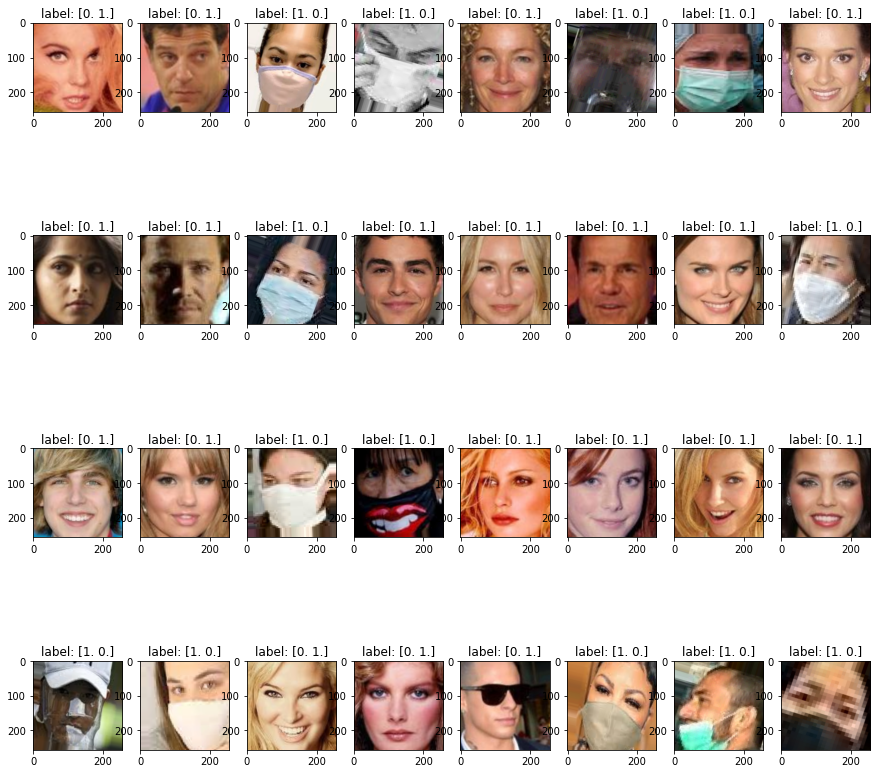

In [3]:
import matplotlib.pyplot as plt

# Define subplots
fig, axs = plt.subplots(4, 8, figsize=(15, 15))

# Convert batch to numpy iterator and retrieve the first batch
[image_batch, image_labels] = iter(train_data).next() 

# Show images
for i, ax in enumerate(axs.ravel()):
    ax.imshow(image_batch[i]/255)
    ax.set_title("label: {}".format(image_labels[i]))

### Define model, compile and train 
Apply Keras model functional API to connect VGG16 model with custom fully-connected layers.

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications import VGG16, MobileNetV2

# Define input shape
input_shape = (256, 256, 3)

# # Define vgg16 model 
# vgg16_model = VGG16(include_top= False, input_shape= input_shape)

# Define mobilenetv2 model
mobileNet_model = MobileNetV2(include_top= False, input_shape= input_shape)

# Freeze VGG16 layers
for layer in mobileNet_model.layers:
        layer.trainable = False

# Define fully-connected layers architecture
flatten = Flatten()(mobileNet_model.output)
x = Dense(256,activation='relu',
#           kernel_initializer='he_normal',
          name='fully_connect_1'
         )(flatten)
x = Dropout(0.25, name='dropout_1')(x)
x = Dense(128,activation='relu',
#           kernel_initializer='he_normal',
          name='fully_connect_2'
         )(x)
x = Dropout(0.25, name='dropout_2')(x)
x = Dense(64,activation='relu',
#           kernel_initializer='he_normal',
          name='fully_connect_3'
         )(x)
x = Dropout(0.25, name='dropout_3')(x)
x = Dense(32,activation='relu',
#           kernel_initializer='he_normal',
          name='fully_connect_4'
         )(x)
output_layer = Dense(2,activation='softmax',
#           kernel_initializer='he_normal',
          name='softmax'
         )(x)

# Construct model
model = Model(mobileNet_model.input, output_layer)

# Show model architechture
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [5]:
# Compile model
model.compile(optimizer= 'adam',
              loss= 'categorical_crossentropy',
              metrics= 'accuracy'
             )

Epoch 1/10
31/31 [==============================] - 32s 708ms/step - loss: 2.5746 - accuracy: 0.6822 - val_loss: 0.5936 - val_accuracy: 0.9187
Epoch 2/10
31/31 [==============================] - 14s 442ms/step - loss: 1.0053 - accuracy: 0.8734 - val_loss: 0.2881 - val_accuracy: 0.9488
Epoch 3/10
31/31 [==============================] - 14s 443ms/step - loss: 0.4632 - accuracy: 0.9177 - val_loss: 0.1713 - val_accuracy: 0.9525
Epoch 4/10
31/31 [==============================] - 14s 458ms/step - loss: 0.3679 - accuracy: 0.9014 - val_loss: 0.1541 - val_accuracy: 0.9463
Epoch 5/10
31/31 [==============================] - 14s 450ms/step - loss: 0.3301 - accuracy: 0.9172 - val_loss: 0.1065 - val_accuracy: 0.9613
Epoch 6/10
31/31 [==============================] - 14s 455ms/step - loss: 0.2564 - accuracy: 0.9416 - val_loss: 0.0929 - val_accuracy: 0.9638
Epoch 7/10
31/31 [==============================] - 14s 447ms/step - loss: 0.1810 - accuracy: 0.9504 - val_loss: 0.1195 - val_accuracy: 0.9650

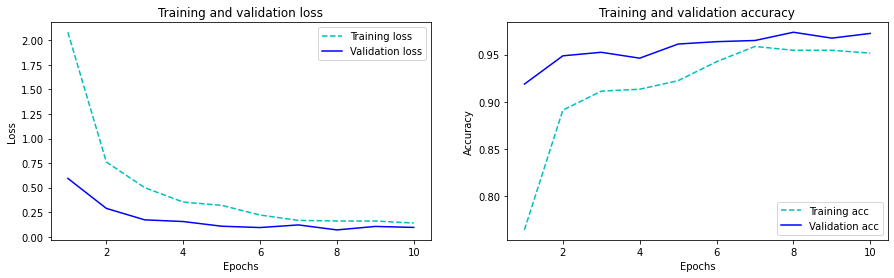

In [6]:
# Define steps
steps_per_epoch = 1000//32
validation_steps = 800//32
epochs = 10

# train baseline model
history = model.fit(x= train_data,
                  steps_per_epoch=steps_per_epoch,
                  validation_data= val_data,
                  validation_steps= validation_steps,
                  epochs=epochs)

# Save model
model.save('face_mask_detection_model.h5')

# Evaluate model
print(model.evaluate(test_data))

# Training result
show_result(history)

### Test the model with test dataset

In [7]:
from sklearn.metrics import classification_report

# Get label of each image from batched dataset
y = np.concatenate([ y for x, y in test_data], axis=0)

# Predict each image
pred = model.predict(test_data)

# Convert from one-hot encoding format to integer (for using in classification report)
pred = np.argmax(pred, axis=-1)
y = np.argmax(y, axis=-1)

# Show model performance on test dataset
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       483
           1       0.95      0.98      0.97       509

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992



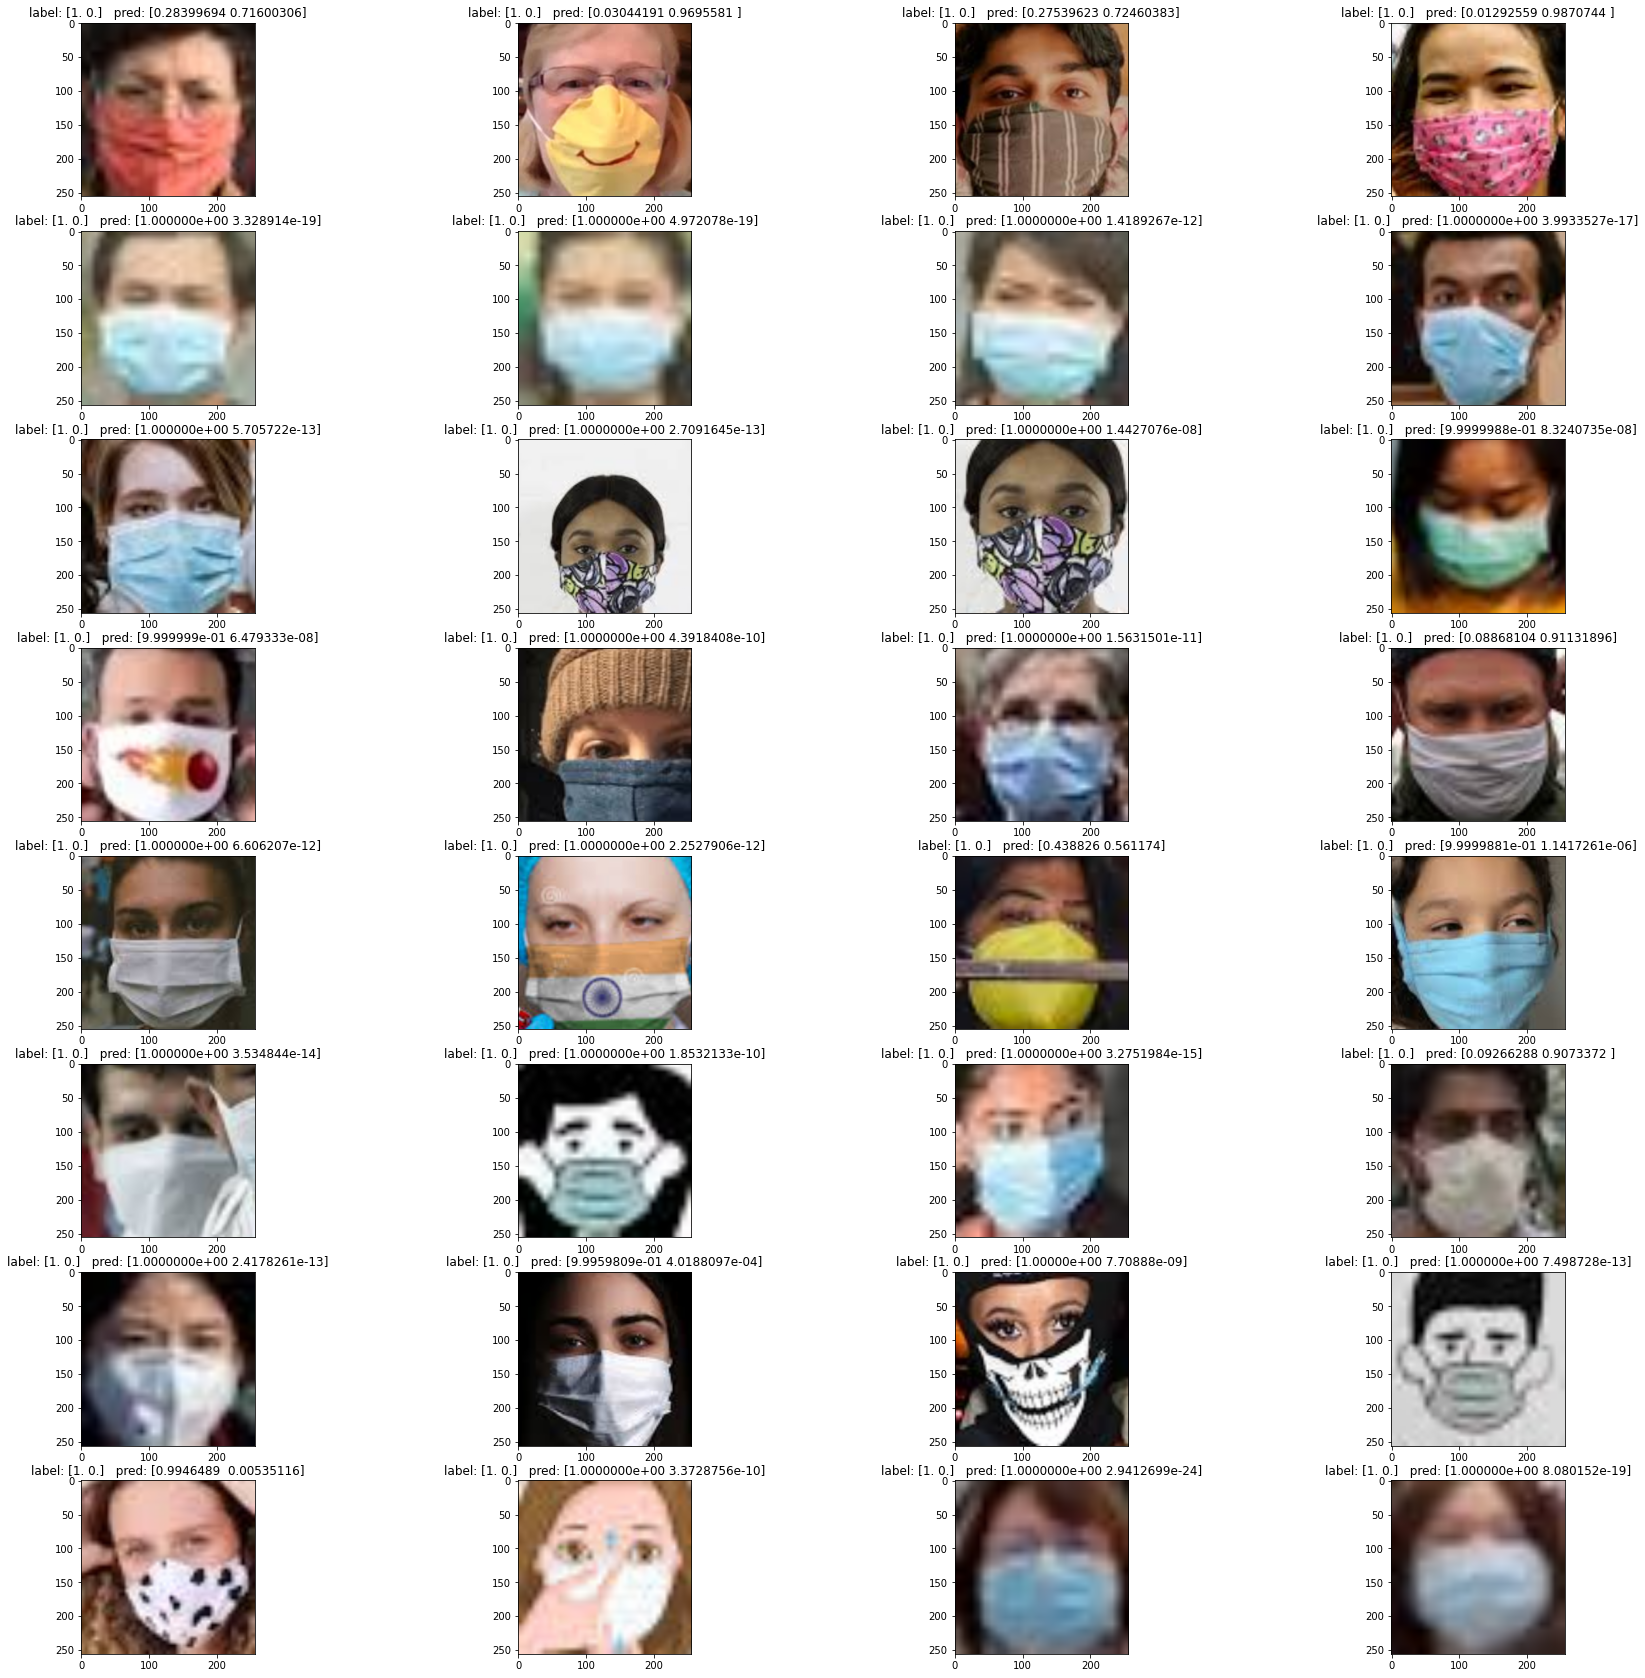

In [8]:
# Get first batch from test dataset
[test_data_batch, test_label_batch] = iter(test_data).next()

# Predict that batch
test_pred = model.predict(test_data_batch)

# Define subplots
fig, axs = plt.subplots(8, 4, figsize=(30,30))

# Show result
for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_data_batch[i]/255)
    ax.set_title('label: {}   pred: {}'.format(test_label_batch[i], test_pred[i]))

### Further improvement
Apply Data augmentation to enhance model's robustness to real world data.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Define augmentation
aug_gen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=False
            )

# Load train, val and test dataset with augmentation
train_aug = aug_gen.flow_from_directory(ROOT_DIR + TRAIN_DIR)
val_aug = aug_gen.flow_from_directory(ROOT_DIR + VAL_DIR)
test_aug = aug_gen.flow_from_directory(ROOT_DIR + TEST_DIR, shuffle= False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


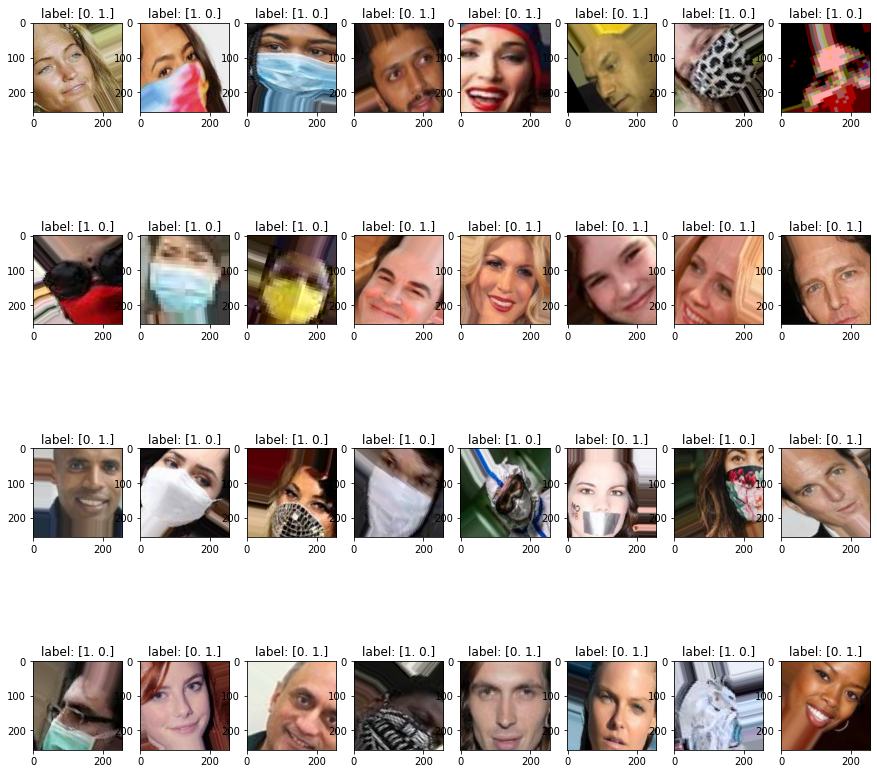

In [10]:
# Define subplots
fig, axs = plt.subplots(4, 8, figsize=(15, 15))

# Convert batch to numpy iterator and retrieve the first batch
[image_batch, image_labels] = train_aug.next() 

# Show images
for i, ax in enumerate(axs.ravel()):
    ax.imshow(image_batch[i]/255)
    ax.set_title("label: {}".format(image_labels[i]))

Epoch 1/10
31/31 [==============================] - 33s 1s/step - loss: 1.0668 - accuracy: 0.7137 - val_loss: 0.3541 - val_accuracy: 0.8637
Epoch 2/10
31/31 [==============================] - 30s 969ms/step - loss: 0.4759 - accuracy: 0.8065 - val_loss: 0.3000 - val_accuracy: 0.8875
Epoch 3/10
31/31 [==============================] - 30s 981ms/step - loss: 0.3511 - accuracy: 0.8538 - val_loss: 0.2847 - val_accuracy: 0.8813
Epoch 4/10
31/31 [==============================] - 29s 954ms/step - loss: 0.3473 - accuracy: 0.8629 - val_loss: 0.2412 - val_accuracy: 0.8963
Epoch 5/10
31/31 [==============================] - 30s 988ms/step - loss: 0.3267 - accuracy: 0.8720 - val_loss: 0.2710 - val_accuracy: 0.8850
Epoch 6/10
31/31 [==============================] - 30s 967ms/step - loss: 0.2876 - accuracy: 0.8901 - val_loss: 0.2092 - val_accuracy: 0.9175
Epoch 7/10
31/31 [==============================] - 30s 983ms/step - loss: 0.2621 - accuracy: 0.8982 - val_loss: 0.2188 - val_accuracy: 0.9150
Ep

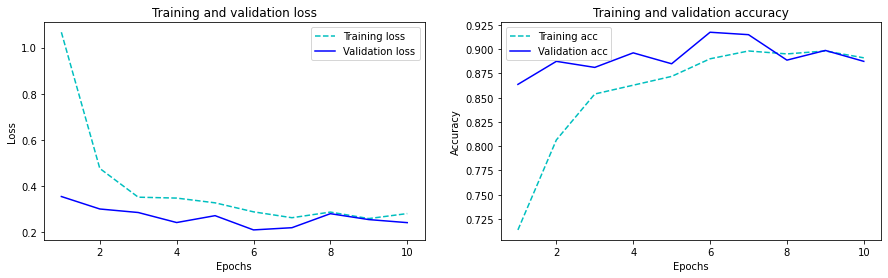

In [11]:
# Define steps
steps_per_epoch = 1000//32
validation_steps = 800//32
epochs = 10

# train baseline model
history = model.fit(x= train_aug,
                  steps_per_epoch=steps_per_epoch,
                  validation_data= val_aug,
                  validation_steps= validation_steps,
                  epochs=epochs)

# Save model
model.save('face_mask_detection_model_aug.h5')

# Evaluate model
print(model.evaluate(val_aug))

# Training result
show_result(history)

In [12]:
# Get label of each image from batched dataset
y = np.concatenate([test_aug.next()[1] for _ in range(steps_per_epoch)], axis=0)

# Predict each image
pred = model.predict(test_aug)

# Convert from one-hot encoding format to integer (for using in classification report)
pred = np.argmax(pred, axis=-1)
y = np.argmax(y, axis=-1)

# Show model performance on test dataset
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       483
           1       0.92      0.89      0.90       509

    accuracy                           0.90       992
   macro avg       0.90      0.90      0.90       992
weighted avg       0.90      0.90      0.90       992



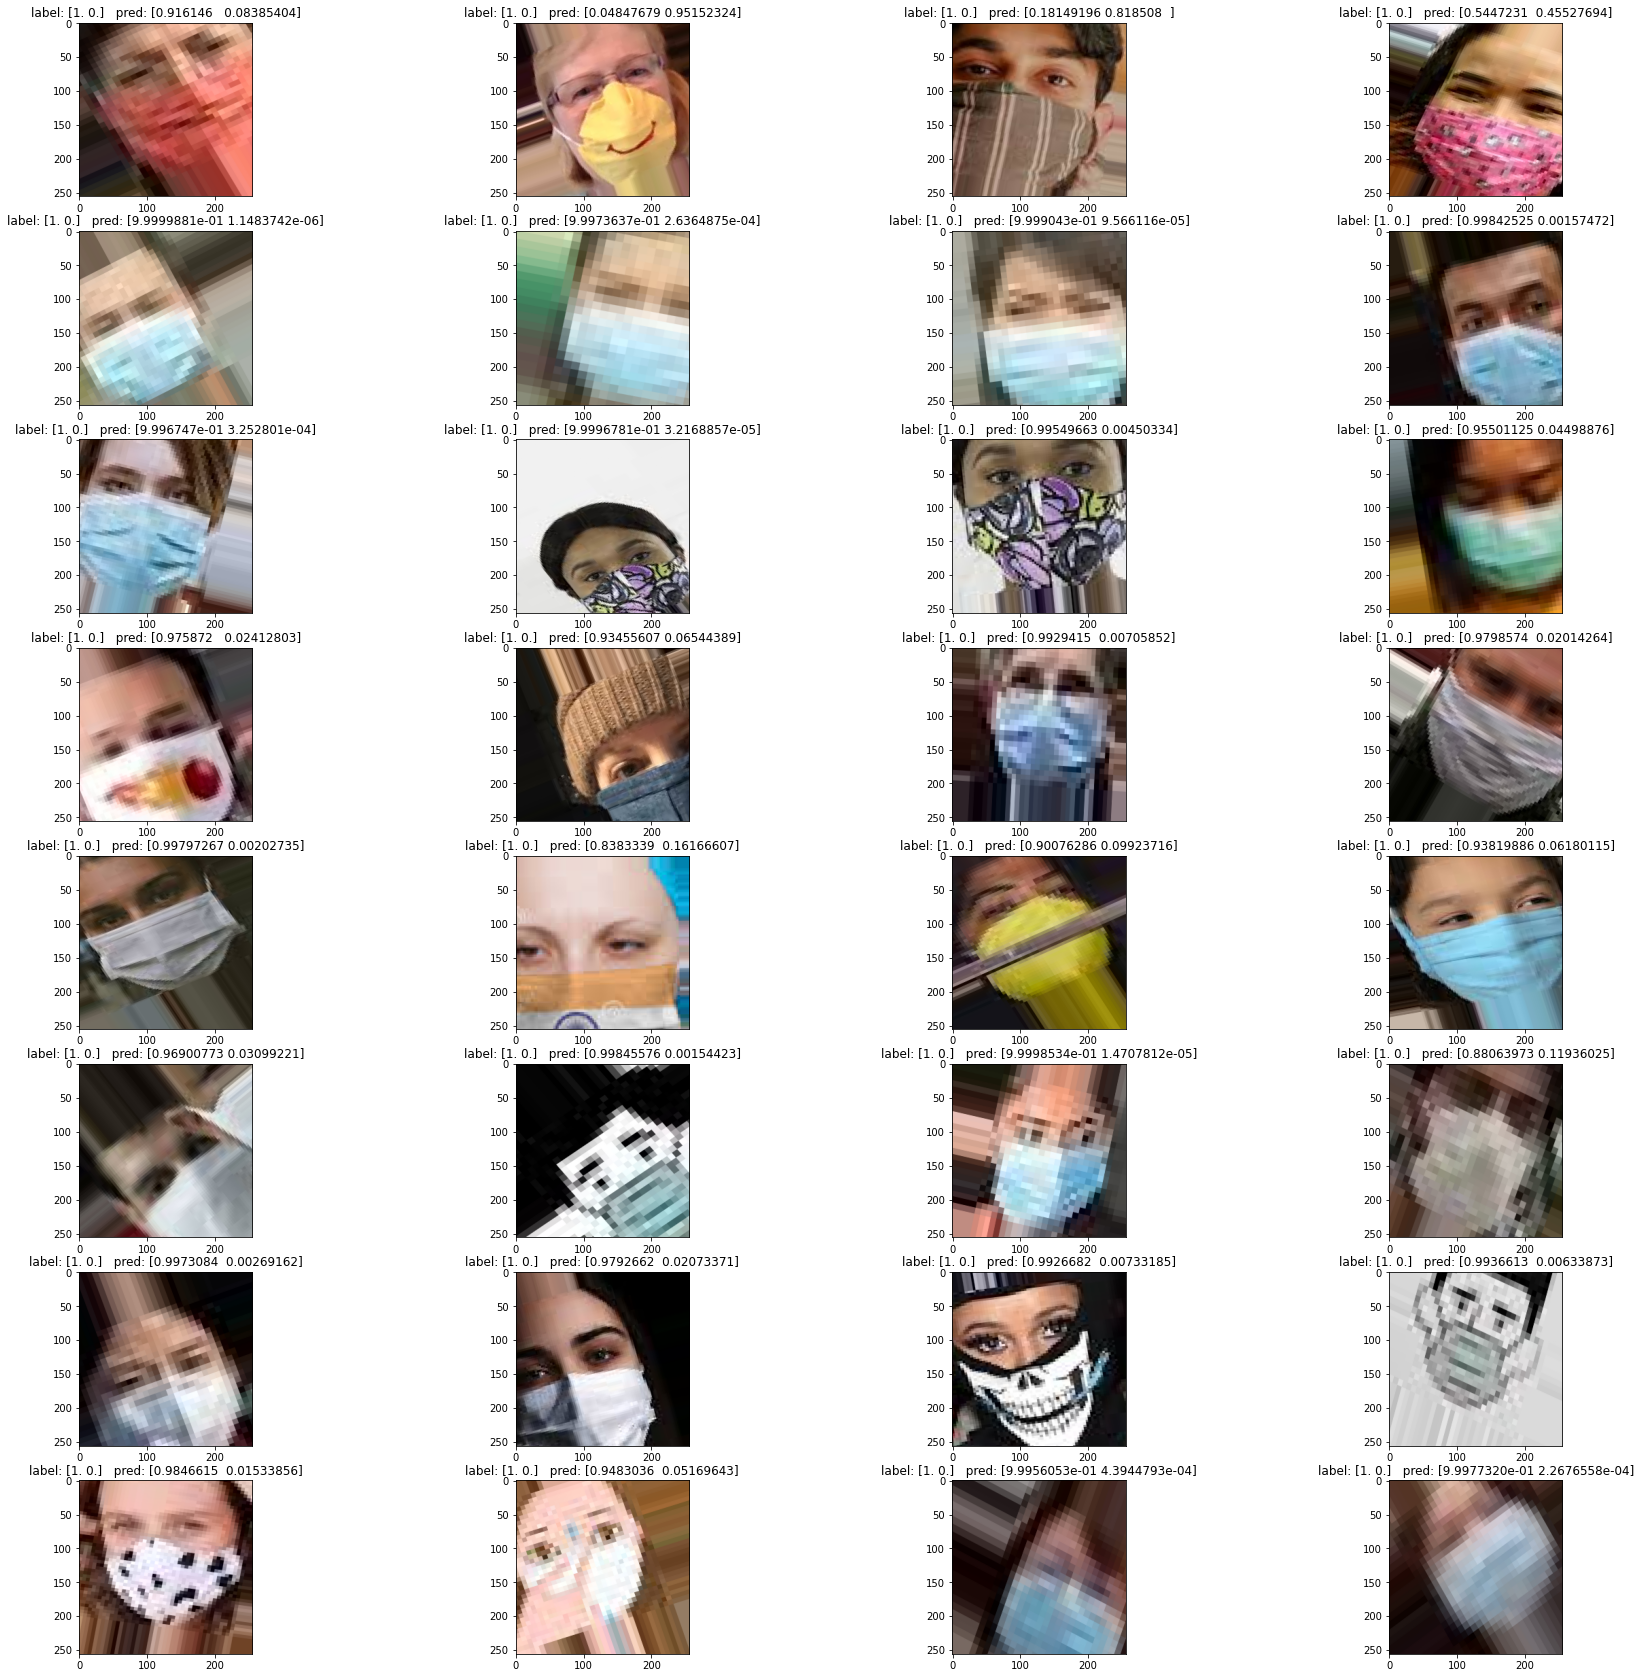

In [13]:
# Get first batch from test dataset
[test_aug_batch, test_label_batch] = test_aug.next()

# Predict that batch
test_pred = model.predict(test_aug_batch)

# Define subplots
fig, axs = plt.subplots(8, 4, figsize=(30,30))

# Show result
for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_aug_batch[i]/255)
    ax.set_title('label: {}   pred: {}'.format(test_label_batch[i], test_pred[i]))